# Numerics for partial differential equations 2

# TP 1 - scalar conservation laws


## Exercise 1: Linear transport

$$
\begin{cases}
\partial_t u + c \partial_x u = 0, & \quad\ \text{on}\ \Omega \times (0,T) \\
u(b, t) = g(t), & \quad t \in (0,T) \\
u(0,x) = u_0(x), & \quad x \in \Omega \subset \mathbb{R}
\end{cases}
$$


(a) Let $c < 0$ (transport speed), $\Omega = [0,b]$ and $T>0$ (final time), we have:

$$
\begin{cases}
\partial_t u + c \partial_x u = 0, & \quad\ (x,t) \in [0,b] \times (0,T) \\
u(b, t) = g(t), & \quad t \in (0,T) \\
u(0,x) = u_0(x), & \quad x \in [0,b]
\end{cases}
$$

Let $\phi \in C_c^{\infty}([0,b] \times (0,T))$ be a test function. We have:

$$
\begin{aligned}
\int_0^T \int_0^b (\partial_t u + c \partial_x u) \phi \, dx \, dt =0 \\
\Leftrightarrow \int_0^T \int_0^b \partial_t u \phi \, dx \, dt + \int_0^T \int_0^b c \partial_x u \phi \, dx \, dt =0 \\
\end{aligned}
$$

We integrate by parts the first term:

$$
\begin{aligned}
\left[ \int_0^b u(x,t) \phi(x,t) \, dx \right]_{t=0}^{t=T} - \int_0^T \int_0^b u \partial_t \phi \, dx \, dt  \\
= \int_0^b u(x,T) \phi(x,T) \, dx - \int_0^b \underbrace{u(x,0)}_{u_0(x)} \phi(x,0) \, dx - \int_0^T \int_0^b u \partial_t \phi \, dx \, dt \\
= \int_0^b u(x,T) \phi(x,T) \, dx - \int_0^b u_0(x) \phi(x,0) \, dx - \int_0^T \int_0^b u \partial_t \phi \, dx \, dt
\end{aligned}
$$

We integrate by parts the second term:

$$
\begin{aligned}
\underbrace{\left[ \int_0^T c u(x,t) \phi(x,t) \, dt \right]_{x=0}^{x=b}}_{=0, \phi \in C_c^{\infty}([0,b] \times (0,T))} - \int_0^T \int_0^b c u \partial_x \phi \, dx \, dt \\
= - \int_0^T \int_0^b c u \partial_x \phi \, dx \, dt
\end{aligned}
$$

Therefore, we have:

$$
\begin{aligned}
\int_0^b u(x,T) \phi(x,T) \, dx - \int_0^b u_0(x) \phi(x,0) \, dx - \int_0^T \int_0^b u (\partial_t \phi + c \partial_x \phi) \, dx \, dt = 0 \\
\end{aligned}
$$

Hence, according to Definition 1.8,
$$u \in L_{loc}^\infty([0,b] \times (0,T))$$
is a weak solution of the transport equation if the above equation holds for all $\phi \in C_c^{\infty}([0,b] \times (0,T))$.


Using the method of characteristics, we have:

$$
\begin{cases}
x' = c\\
x(0) = x_0
\end{cases}
 \Rightarrow x(t) = x_0 + ct
$$

The characteristic curve passing through $(x_0,0)$ is given by $x(t) = x_0 + ct$. The initial condition $u(0,x) = u_0(x)$ implies that $u(t,x(t)) = u_0(x_0)$. Therefore, the solution of the transport equation is given by:

$$ u(t,x) = u_0(x-ct) $$

Taking into account the boundary condition $u(b,t) = g(t)$, we have:

$$
u(x, t) =
\begin{cases}
u_0(x-ct), & \quad x \in [0,b] \text{ and } t \in [0,T] \\
g(t - x/c), & \quad x > b \text{ and } t \in [0,T]
\end{cases}
$$


### Godunov scheme:


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_lin_transport(x, t, u0, g, b, c):
    """Compute the exact solution based on characteristics and boundary condition"""
    u_exact = np.zeros_like(x)

    for i in range(len(x)):
        # Calculate the transported position
        xi = x[i] - c * t

        if xi > b[1]:
            u_exact[i] = g(t - x[i] / c)  # Right boundary condition
        else:
            u_exact[i] = u0(xi)  # Initial condition transported

    return u_exact

In [3]:
# Boundary Conditions and Initial Condition u0
def g1(t):
    return np.sin(2 * np.pi * t)


def g2(t):
    return np.sin(2 * np.pi * t) + 1


def u0(x):
    return 0

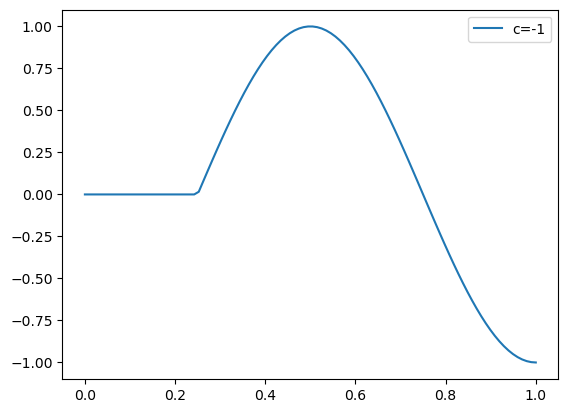

In [4]:
# Plot of the exact solution
b = [0, 1]  # Boundary
T = 0.75  # Final time
Nx = 100  # Number of cells
c1 = -1.0  # Speed of the wave
c2 = -2.0

x = np.linspace(b[0], b[1], Nx)
y = exact_lin_transport(x, T, u0, g1, b, c1)

plt.plot(x, y, label="c=-1")
plt.legend()
plt.show()

In [5]:
class Mesh:
    def __init__(self, N, b):
        if N <= 0:
            raise ValueError("N must be > 0 ")

        self.N = N
        self.bL = b[0]
        self.bR = b[1]
        self.dx = np.abs(b[1] - b[0]) / N
        self.Nf = N + 1  # Number of cell interfaces
        # Cell centers
        self.xi = np.array([self.bL + self.dx * (i + 0.5) for i in range(N)])
        # Cell interfaces
        self.x_half = np.array([self.bL + self.dx * i for i in range(self.Nf)])

In [6]:
# Test
m = Mesh(2, [0, 2])
print(m.xi)
print(m.x_half)
print(m.dx)

[0.5 1.5]
[0. 1. 2.]
1.0


In [7]:
def RS_transport(uL, uR, xi, c):
    """Compute the Riemann solution for the transport problem."""
    if xi < c:
        return uL  # Information is coming from the left
    else:
        return uR  # Information is coming from the right


def num_flux_godunov(uL, uR, c, RS, f):
    """Compute the numerical flux using Godunov's method."""
    # f_prime = lambda u: c
    # F = lambda uR, uL: 0.5 * (f(uL) + f(uR)) - 0.5 * np.max(np.abs(f_prime(uL), f_prime(uR))) * (uR - uL)
    return f(RS(uL, uR, 0, c))
    # return F(uL, uR)

tf:  0.1


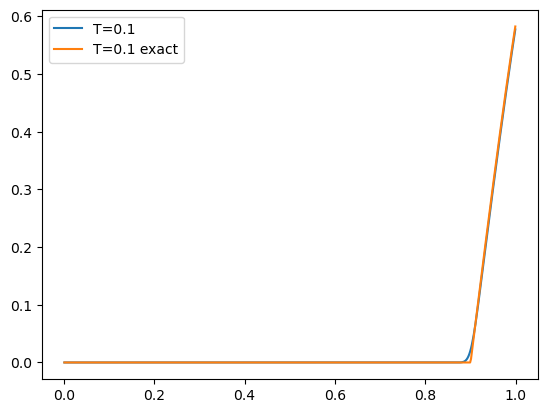

tf:  0.3


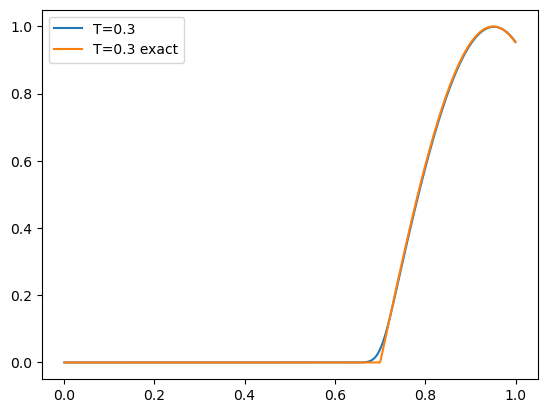

tf:  0.5


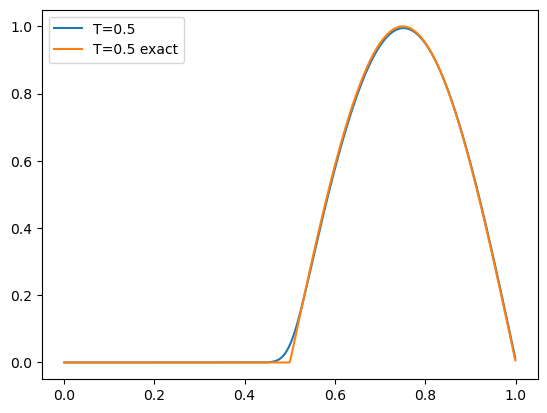

tf:  0.75


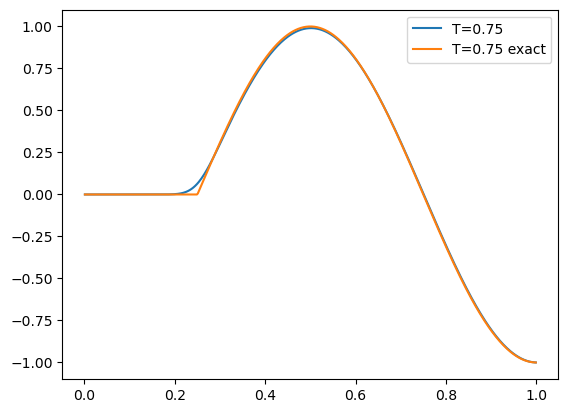

In [8]:
def Godunov_scheme(u0, b, g, Nx, cfl, T, c):
    """Solve the linear transport equation using Godunov's scheme."""
    m = Mesh(Nx, b)
    x = m.xi
    dx = m.dx
    dt = cfl * dx / np.abs(c)
    Nt = int(np.ceil(T / dt))  # Nb of time step
    t = Nt * dt  # To check the final time
    f = lambda u: c * u  # Flux function

    u = np.zeros(Nx)
    # Initial condition
    for i in range(Nx):
        u[i] = u0(x[i])

    for n in range(Nt):
        u_new = np.copy(u)
        for i in range(1, Nx - 1):
            flux_left = num_flux_godunov(u[i - 1], u[i], c, RS_transport, f)
            flux_right = num_flux_godunov(u[i], u[i + 1], c, RS_transport, f)
            u_new[i] = u[i] - (dt / dx) * (flux_right - flux_left)

        # Boundary conditions
        u_ex = exact_lin_transport(x, n * dt, u0, g, b, c)
        u_new[0] = u_ex[0]
        u_new[-1] = u_ex[-1]
        # u_new[0] = 0
        # u_new[-1] = g(n * dt - x[-1] /c )

        u = u_new

    return x, t, u


# Test
T_values = [0.1, 0.3, 0.5, 0.75]
Nx = 500
cfl = 0.5
b = [0, 1]
T = 0.75
c1 = -1
tf = []


for T in T_values:
    x, t, u = Godunov_scheme(u0, b, g1, Nx, cfl, T, c1)
    u_ex = exact_lin_transport(x, T, u0, g1, b, c1)
    print("tf: ", t)
    plt.plot(x, u, label=f"T={T}")
    plt.plot(x, u_ex, label=f"T={T} exact")
    plt.legend()
    plt.show()

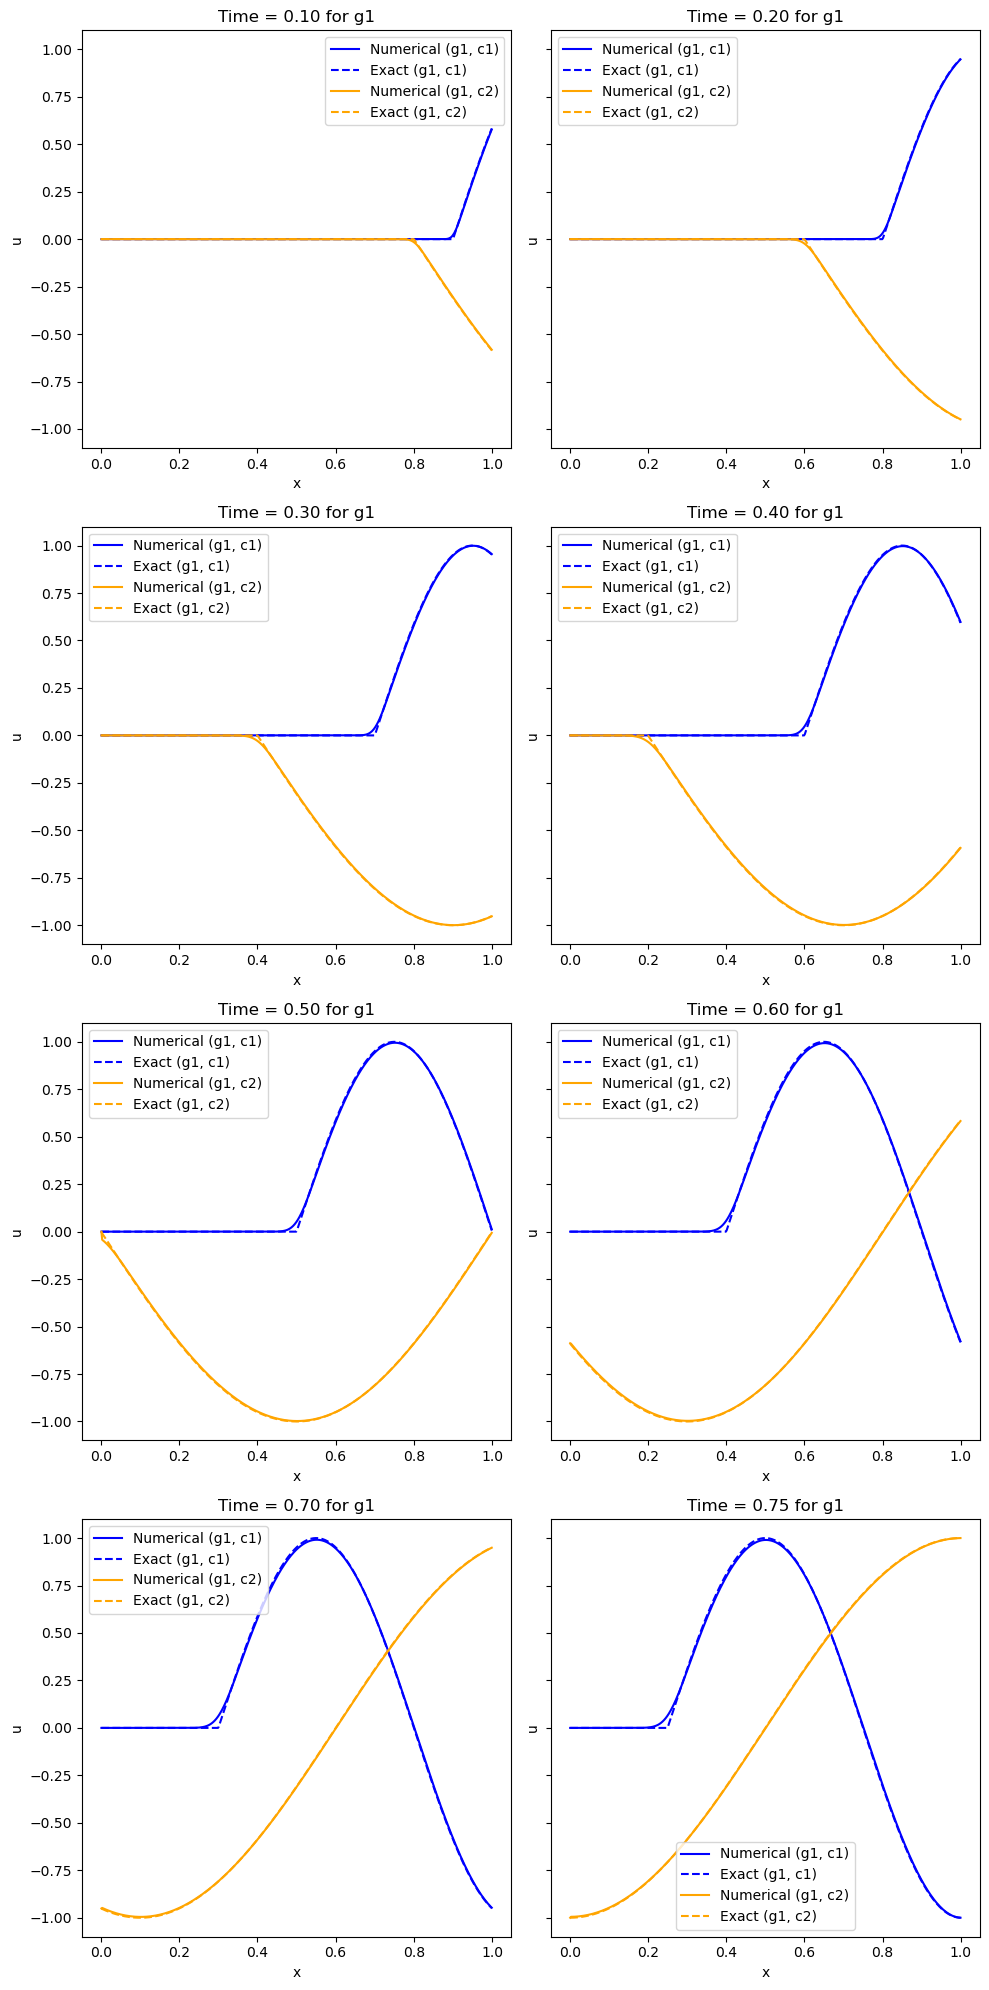

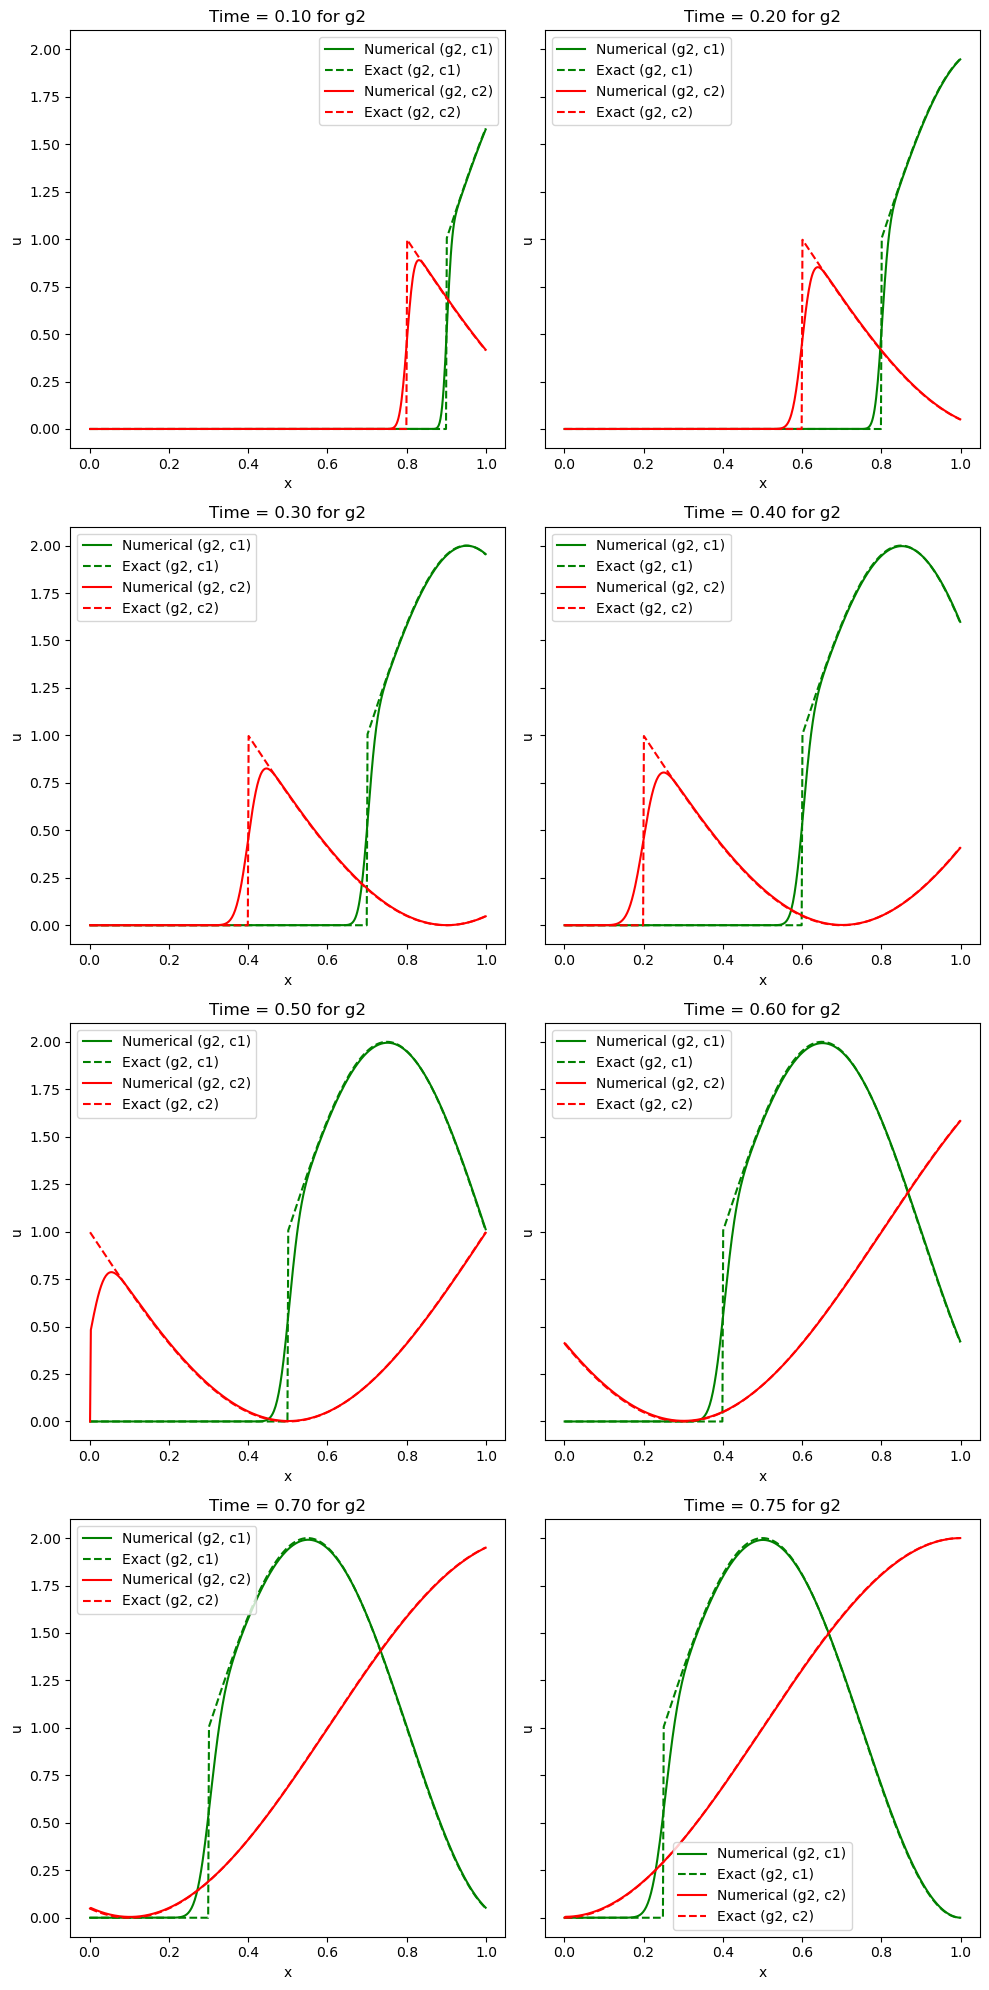

In [9]:
T_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75]
Nx = 500
cfl = 0.5
c1 = -1.0
c2 = -2.0

# Plots made by chatGPT:
fig_g1, axs_g1 = plt.subplots(4, 2, figsize=(10, 20), sharey=True)

for i, T in enumerate(T_values):
    x, t, u1 = Godunov_scheme(u0, b, g1, Nx, cfl, T, c1)
    x, t, u2 = Godunov_scheme(u0, b, g1, Nx, cfl, T, c2)

    u_exact1 = exact_lin_transport(x, T, u0, g1, b, c1)
    u_exact2 = exact_lin_transport(x, T, u0, g1, b, c2)

    row = i // 2  # Determine row based on index
    col = i % 2  # Column for g1

    axs_g1[row, col].plot(x, u1, label="Numerical (g1, c1)", color="blue")
    axs_g1[row, col].plot(
        x, u_exact1, label="Exact (g1, c1)", linestyle="--", color="blue"
    )
    axs_g1[row, col].plot(x, u2, label="Numerical (g1, c2)", color="orange")
    axs_g1[row, col].plot(
        x, u_exact2, label="Exact (g1, c2)", linestyle="--", color="orange"
    )
    axs_g1[row, col].set_title(f"Time = {T:.2f} for g1")
    axs_g1[row, col].legend()
    axs_g1[row, col].set_xlabel("x")
    axs_g1[row, col].set_ylabel("u")

plt.tight_layout()
plt.show()

fig_g2, axs_g2 = plt.subplots(4, 2, figsize=(10, 20), sharey=True)

for i, T in enumerate(T_values):
    x, t, u3 = Godunov_scheme(u0, b, g2, Nx, cfl, T, c1)
    x, t, u4 = Godunov_scheme(u0, b, g2, Nx, cfl, T, c2)

    u_exact3 = exact_lin_transport(x, T, u0, g2, b, c1)
    u_exact4 = exact_lin_transport(x, T, u0, g2, b, c2)

    row = i // 2  # Determine row based on index
    col = i % 2  # Column for g2

    axs_g2[row, col].plot(x, u3, label="Numerical (g2, c1)", color="green")
    axs_g2[row, col].plot(
        x, u_exact3, label="Exact (g2, c1)", linestyle="--", color="green"
    )
    axs_g2[row, col].plot(x, u4, label="Numerical (g2, c2)", color="red")
    axs_g2[row, col].plot(
        x, u_exact4, label="Exact (g2, c2)", linestyle="--", color="red"
    )
    axs_g2[row, col].set_title(f"Time = {T:.2f} for g2")
    axs_g2[row, col].legend()
    axs_g2[row, col].set_xlabel("x")
    axs_g2[row, col].set_ylabel("u")

plt.tight_layout()
plt.show()

We can notice the diffusion near the discontinuities. This can be attenuated by refining the mesh (i.e. by increasing $Nx$)


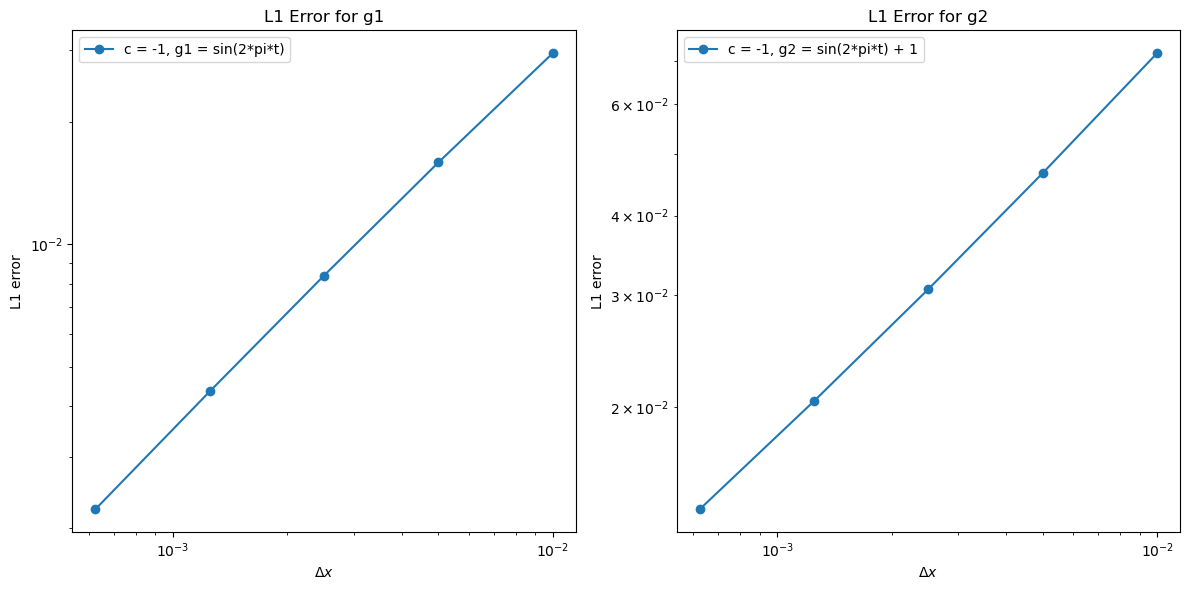

In [10]:
def L1_error(u_num, u_exact, dx):
    """Calculate the L1 error between the numerical and exact solution."""
    return np.sum(np.abs(u_num - u_exact)) * dx


# Test case parameters
T1 = 0.75  # Final time
N = 50  # Base number of cells
c = -1.0  # Transport speed
b = [0, 1]  # Define the boundary

# Define mesh refinement factors
refinement_factors = [2**k for k in range(1, 6)]
errors_g1 = []
errors_g2 = []
dx_values = []

for factor in refinement_factors:
    Nx = N * factor
    mesh = Mesh(Nx, b)

    # Solve for g1
    x, t, u_numerical_g1 = Godunov_scheme(u0, b, g1, Nx, cfl, T1, c)
    u_exact_g1 = exact_lin_transport(x, T1, u0, g1, b, c)

    # Solve for g2
    x, t, u_numerical_g2 = Godunov_scheme(u0, b, g2, Nx, cfl, T1, c)
    u_exact_g2 = exact_lin_transport(x, T1, u0, g2, b, c)

    dx = mesh.dx
    dx_values.append(dx)

    error_g1 = L1_error(u_numerical_g1, u_exact_g1, dx)
    error_g2 = L1_error(u_numerical_g2, u_exact_g2, dx)

    errors_g1.append(error_g1)
    errors_g2.append(error_g2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for g1
ax[0].loglog(dx_values, errors_g1, "-o", label="c = -1, g1 = sin(2*pi*t)")
ax[0].set_xlabel(r"$\Delta x$")
ax[0].set_ylabel("L1 error")
ax[0].set_title("L1 Error for g1")
ax[0].legend()

# Plot for g2
ax[1].loglog(dx_values, errors_g2, "-o", label="c = -1, g2 = sin(2*pi*t) + 1")
ax[1].set_xlabel(r"$\Delta x$")
ax[1].set_ylabel("L1 error")
ax[1].set_title("L1 Error for g2")
ax[1].legend()

plt.tight_layout()
plt.show()

The slope of our error curve on a log-log scale looks like to be approximately 1.  
The error decreases with the mesh size, which indicate that the Godunov scheme is converging.  
The slope gives an idea of the convergence rate of the method.  
The Godunov method is first order accurate, so we expect the slope to be 1.  
Different slope values could be due to an error of implementation, a mesh too coarse around discontinuities, numerical diffusion, bad CFL, different boundary conditions, etc.


### MUSCL Scheme:


In [11]:
def minmod(alpha, beta, gamma):
    """Calculate the minmod function."""
    if alpha > 0 and beta > 0 and gamma > 0:
        return min(alpha, beta, gamma)
    elif alpha < 0 and beta < 0 and gamma < 0:
        return max(alpha, beta, gamma)
    else:
        return 0


def slopes(u, uL, uR, Nc):
    """Calculate the slopes for the MUSCL reconstruction."""
    u_slope = np.zeros(Nc)
    for i in range(1, Nc - 1):
        alpha = 2 * (u[i] - u[i - 1])
        beta = 0.5 * (u[i + 1] - u[i - 1])
        gamma = 2 * (u[i + 1] - u[i])
        u_slope[i] = minmod(alpha, beta, gamma)
    return u_slope


def muscl_reconstruction(u, uL, uR, dx):
    """Reconstruct the solution using MUSCL."""
    N = len(u)
    u_reconstructed = np.zeros(N)
    u_slope = slopes(u, uL, uR, N)

    # Extrapolate cell averages
    for i in range(1, N - 1):
        u_reconstructed[i] = u[i] + 0.5 * u_slope[i] * dx

    # Extrapolate boundary values
    u_reconstructed[0] = uL + u_slope[1] * dx
    u_reconstructed[N - 1] = uR - u_slope[N - 2] * dx

    return u_reconstructed


def muscl_scheme(u0, b, g, c, Nx, cfl, T):
    """Solve the linear transport equation using the MUSCL scheme."""
    m = Mesh(Nx, b)
    x = m.xi
    dx = m.dx
    dt = cfl * dx / np.abs(c)
    Nt = int(np.ceil(T / dt))
    f = lambda u: c * u

    u = np.zeros(Nx)

    # Apply initial condition
    for i in range(Nx):
        u[i] = u0(x[i])

    # SSP-RK2 time-stepping loop
    for n in range(Nt):
        # First stage
        u_half = muscl_reconstruction(u, u[0], u[-1], dx)

        # Compute numerical flux at each interface
        for i in range(1, Nx - 1):
            flux_left = num_flux_godunov(u_half[i - 1], u_half[i], c, RS_transport, f)
            flux_right = num_flux_godunov(u_half[i], u_half[i + 1], c, RS_transport, f)

            # Update the solution using the Godunov scheme
            u[i] = u[i] - dt / dx * (flux_right - flux_left)

        # Apply boundary conditions using the Riemann solution
        u_ex = exact_lin_transport(x, n * dt, u0, g, b, c)
        u[0] = u_ex[0]
        u[-1] = u_ex[-1]
        # u[0] = 0
        # u[-1] = g(n * dt - x[-1] / c)

    return x, u

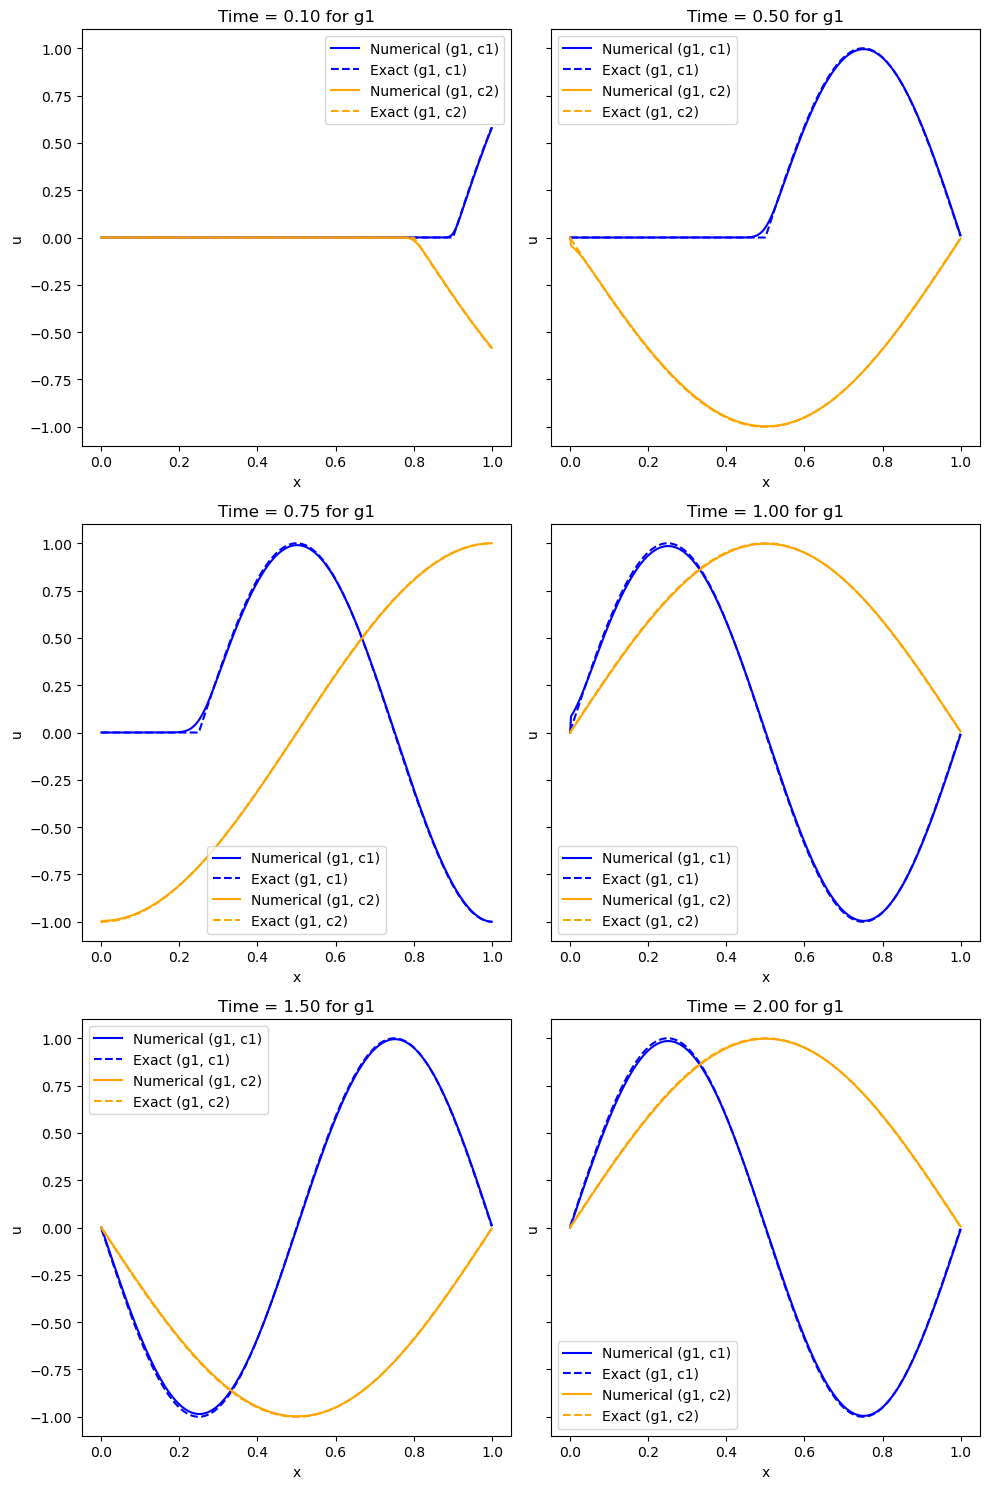

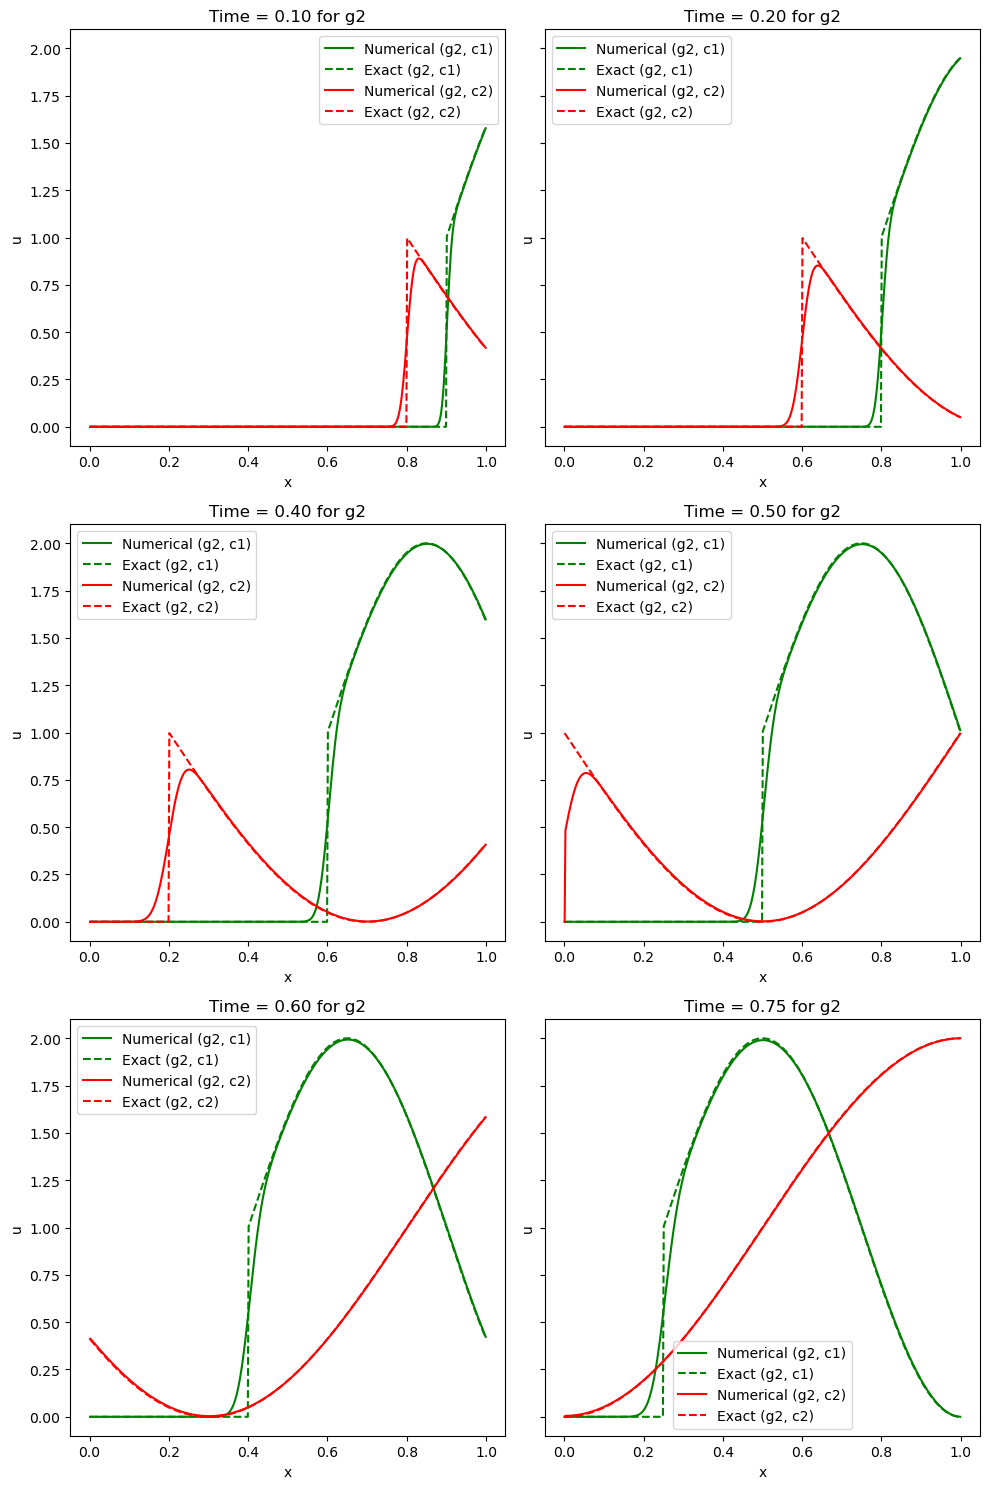

In [12]:
# Plots
b = [0, 1]
T1 = [0.1, 0.5, 0.75, 1.0, 1.5, 2.0]
T2 = [0.1, 0.2, 0.4, 0.5, 0.6, 0.75]
Nx = 500
c1 = -1.0
c2 = -2.0

fig_g1, axs_g1 = plt.subplots(3, 2, figsize=(10, 15), sharey=True)

for i, T in enumerate(T1):
    x, u1 = muscl_scheme(u0, b, g1, c1, Nx, cfl, T)
    x, u2 = muscl_scheme(u0, b, g1, c2, Nx, cfl, T)

    u_exact1 = exact_lin_transport(x, T, u0, g1, b, c1)
    u_exact2 = exact_lin_transport(x, T, u0, g1, b, c2)

    row = i // 2  # Determine row based on index
    col = i % 2  # Column for g1

    axs_g1[row, col].plot(x, u1, label="Numerical (g1, c1)", color="blue")
    axs_g1[row, col].plot(
        x, u_exact1, label="Exact (g1, c1)", linestyle="--", color="blue"
    )
    axs_g1[row, col].plot(x, u2, label="Numerical (g1, c2)", color="orange")
    axs_g1[row, col].plot(
        x, u_exact2, label="Exact (g1, c2)", linestyle="--", color="orange"
    )
    axs_g1[row, col].set_title(f"Time = {T:.2f} for g1")
    axs_g1[row, col].legend()
    axs_g1[row, col].set_xlabel("x")
    axs_g1[row, col].set_ylabel("u")

plt.tight_layout()
plt.show()

fig_g2, axs_g2 = plt.subplots(3, 2, figsize=(10, 15), sharey=True)

for i, T in enumerate(T2):
    x, u3 = muscl_scheme(u0, b, g2, c1, Nx, cfl, T)
    x, u4 = muscl_scheme(u0, b, g2, c2, Nx, cfl, T)

    u_exact3 = exact_lin_transport(x, T, u0, g2, b, c1)
    u_exact4 = exact_lin_transport(x, T, u0, g2, b, c2)

    row = i // 2  # Determine row based on index
    col = i % 2  # Column for g2

    axs_g2[row, col].plot(x, u3, label="Numerical (g2, c1)", color="green")
    axs_g2[row, col].plot(
        x, u_exact3, label="Exact (g2, c1)", linestyle="--", color="green"
    )
    axs_g2[row, col].plot(x, u4, label="Numerical (g2, c2)", color="red")
    axs_g2[row, col].plot(
        x, u_exact4, label="Exact (g2, c2)", linestyle="--", color="red"
    )
    axs_g2[row, col].set_title(f"Time = {T:.2f} for g2")
    axs_g2[row, col].legend()
    axs_g2[row, col].set_xlabel("x")
    axs_g2[row, col].set_ylabel("u")

plt.tight_layout()
plt.show()

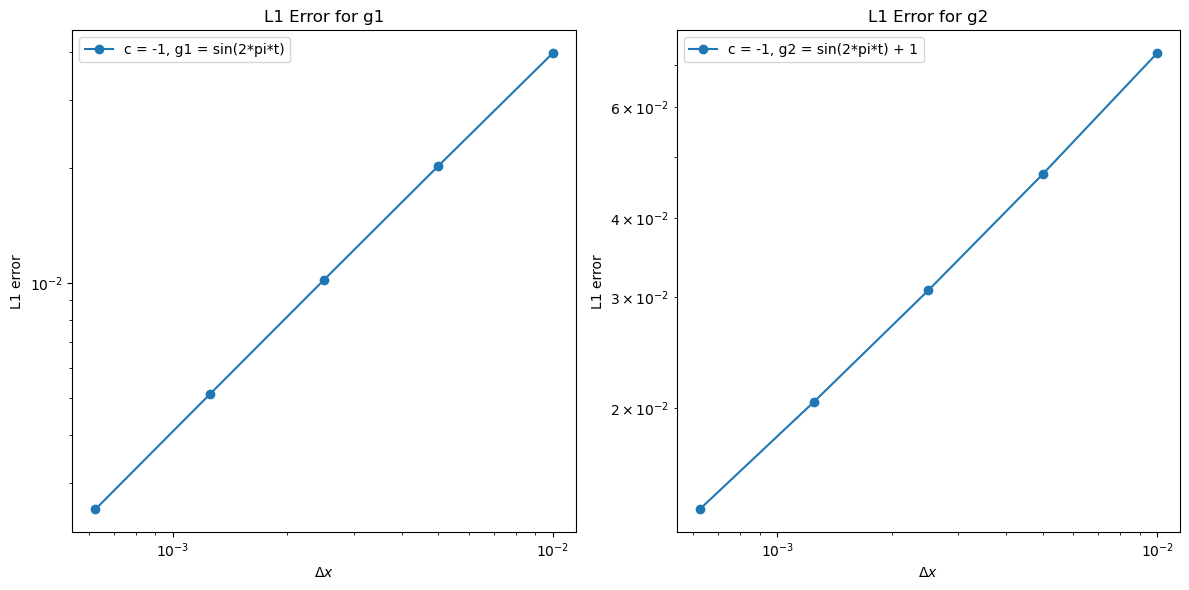

In [13]:
# L1 error calculation
N = 50  # Base number of cells
c = -1.0  # Transport speed
b = [0, 1]  # Define the boundary
T1 = 2
T2 = 0.75

refinement_factors = [2**k for k in range(1, 6)]
errors_g1 = []
errors_g2 = []
dx_values = []

for factor in refinement_factors:
    Nx = N * factor
    mesh = Mesh(Nx, b)

    dx = mesh.dx
    Nx = N * factor
    dx = (b[1] - b[0]) / Nx  # Calculate spatial step size
    dt = 0.9 * dx / abs(c)  # Calculate time step size based on CFL
    Nt_g1 = int(T1 / dt)  # Number of time steps for g1
    Nt_g2 = int(T2 / dt)  # Number of time steps for g2

    x, u_numerical_g1 = muscl_scheme(u0, b, g1, c, Nx, cfl, T1)
    u_exact_g1 = exact_lin_transport(x, T1, u0, g1, b, c)

    x, u_numerical_g2 = muscl_scheme(u0, b, g2, c, Nx, cfl, T2)
    u_exact_g2 = exact_lin_transport(x, T2, u0, g2, b, c)

    dx = mesh.dx
    dx_values.append(dx)

    error_g1 = L1_error(u_numerical_g1, u_exact_g1, dx)
    error_g2 = L1_error(u_numerical_g2, u_exact_g2, dx)

    errors_g1.append(error_g1)
    errors_g2.append(error_g2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for g1
ax[0].loglog(dx_values, errors_g1, "-o", label="c = -1, g1 = sin(2*pi*t)")
ax[0].set_xlabel(r"$\Delta x$")
ax[0].set_ylabel("L1 error")
ax[0].set_title("L1 Error for g1")
ax[0].legend()

# Plot for g2
ax[1].loglog(dx_values, errors_g2, "-o", label="c = -1, g2 = sin(2*pi*t) + 1")
ax[1].set_xlabel(r"$\Delta x$")
ax[1].set_ylabel("L1 error")
ax[1].set_title("L1 Error for g2")
ax[1].legend()

plt.tight_layout()
plt.show()

The slope should approximately be 2 since we use RK2


## Exercise 2: Non-linear scalar conservation laws


$$
\begin{cases}
\partial_t u + \partial_x (\frac{u^2}{d}) = 0, & \quad\ (x,t) \in (-1,2) \times (0,T) \\
u(-1,t) = 1, & \quad t \in (0,T) \\
u(x,0) = \begin{cases} 1 & \text{if }\ x \leq 0 \\
						1-x & \text{if }\ 0 \leq x \leq 1 \\
						0 & \text{if }\ x > 1
						\end{cases}
\end{cases}
$$


(a)
This is a conservation law with a flux $f(u) = \frac{u^2}{d}$.  
We notice that the flux is strictly convex, since:

$$
f'(u) = \frac{2u}{d} \\
f''(u) = \frac{2}{d} > 0, \quad \forall d > 0
$$

Thus, according to the Remark 1.17, if we had $u_L < u_R$ we could derive a weak solution of the form,

$$
u(x,t) = \begin{cases} u_L & \text{if }\ x/t < f'(u_L) \\
						(f')^{-1}(x/t) & \text{if }\ f'(u_L) < x/t < f'(u_R) \\
						u_R & \text{if }\ x/t > f'(u_R)
						\end{cases}
$$

With $f(u)=\frac{u^2}{d}$, $f'(u)=\frac{2u}{d}$, $(f')^{-1}(v)=\frac{vd}{2}$

We will instead use the method of characteristics to solve the problem, we get the following ODE:

$$
\begin{cases}
x' = \frac{2u}{d} \\
x(0) = x_0
\end{cases}
$$

Hence,
$$x(t) = x_0 + \frac{2u_0(x_0)}{d}t$$

We now use the initial condition $u(x,0)$:

- Left region: $u_0(x_0) = 1$ for $x_0<0$

The characteristic becomes

$$
x(t) = 2t/d \cdot 1 + x_0 \\
\Rightarrow u=1 \text{ for } x < 2t/d, \ (\text{since } x_0 <0)
$$

- Right region: $u_0(x_0)=0$ for $x_0>1$

The characteristic becomes

$$
x(t) = 2t/d \cdot 0 + x_0 \\
\Rightarrow u=0 \text{ for } x >1, \ (\text{since } x_0 > 1 > 0)
$$

- Middle region: $u_0(x_0)=1-x$ for $0\leq x \leq 1$.  
  Using the same process gives us a solution that doesn't work so insead we will interpolate between the left and right state.  
  We look for a line :

$$u(x,t) = ax + b$$

At $x=2t/d$ we have $u(x,t)=1$ thus,
$$ 1 = a \cdot 2t/d +b$$

At $x=1$ we have $u(x,t)=0$ thus,

$$
0 = a \cdot 1 +b \\
\Rightarrow b = -a
$$

We substitute $a$ in the first equation:

$$
1 = a \cdot 2t/d - a\\
\Rightarrow 1 = a(2t/d - 1) \\
\Rightarrow a = \frac{1}{2t/d - 1} \Rightarrow b = -\frac{1}{2t/d - 1}
$$

Thus,

$$
u(x,t) = ax + b \\
\Leftrightarrow u(x,t) = \frac{1}{2t/d -1} x -\frac{1}{2t/d -1}\\
\Leftrightarrow u(x,t) = \frac{x-1}{2t/d - 1}
$$

We can define a solution by,

$$
u(x,t) = \begin{cases}
				1 & \text{if } x/t < 2/d \\
				 \frac{x-1}{2t/d - 1} & \text{if } 2/d \leq x/t \leq 1 \\
				0 & \text{if } x/t > 1
				\end{cases}
$$

This function :

- is piecewise continuous
- verifies the Rankine-Hugoniot condition:  
  - At the discontinuity $x/t = 2/d$ we have,
  $$
  u_L = 1, u_R = \frac{2/d-1}{2t/d -1} = 0 \\
  \sigma = \frac{f(u_R)-f(u_L)}{u_R-u_L} = \frac{-1/d}{-1} = \frac{1}{d}
  $$
  Which is what we expect, the RH condition is satisfied.  
  - And at the discontinuity $x/t =1$ we have,
  $$
  u_L = \frac{1-1}{2t/d -1} = 0, u_R=0 \\
  $$
  So the RH condition is trivially satisfied with $\sigma=0$

Hence, $u(x,t)$ is a weak solution of the SCL.


(b) The Riemann solver is given by:

if $u_L < u_R$:

$$
\mathcal{R}(u_L,u_R,x/t)=\begin{cases}
u_L & \text{if } x/t < 2/d  \\
\frac{x-1}{2t/d-1} & \text{if } 2/d \leq x/t \leq 1\\
u_R & \text{if } x/t > 1
\end{cases}
$$

if $u_L \geq u_R$:

$$
\mathcal{R}(u_L,u_R,x/t)=\begin{cases}
u_L & \text{if } x/t < \sigma \\
u_R & \text{if } x/t > \sigma
\end{cases}
$$

where $\sigma = \frac{f(u_R) - f(u_L)}{u_R - u_L}$ is the speed of the shock wave.


In [14]:
def exact_non_lin_transport(x, t, d):
    """Compute the exact solution for the non-linear transport problem."""
    u_exact = np.zeros_like(x)

    for i in range(len(x)):
        if t == 0:
            if x[i] < 0:
                u_exact[i] = 1
            elif 0 <= x[i] <= 1:
                u_exact[i] = 1 - x[i]
            else:
                u_exact[i] = 0
        else:
            if x[i] < 2 * t / d:
                u_exact[i] = 1
            elif x[i] >= 1:
                u_exact[i] = 0
            else:
                a = 2 * t / d
                u_exact[i] = (x[i] - 1) / (a - 1)

    return u_exact

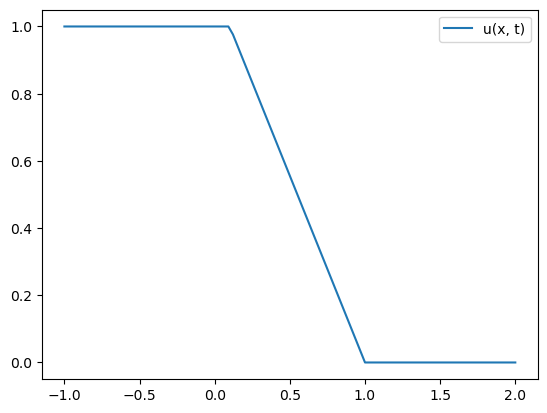

In [15]:
T = 2
x = np.linspace(-1, 2, 100)
u = exact_non_lin_transport(x, 0.1, d=2)

plt.plot(x, u, label="u(x, t)")
plt.legend()
plt.show()

In [16]:
def RS_nonlinear_transport(uL, uR, xi, d):
    """Compute the Riemann solution for the nonlinear problem."""
    f = lambda u: u**2 / d  # flux

    # RH speed for shock waves
    if uL != uR:
        sigma = (f(uR) - f(uL)) / (uR - uL)
    else:
        sigma = 0

    # Case 1: Shock wave (uL >= uR)
    if uL > uR:
        if xi <= sigma:
            return uL
        if xi >= sigma:
            return uR

    # Case 2: Rarefaction wave (uL < uR)
    if uL < uR:
        if xi < 2 / d:
            return uL
        elif xi > 1:
            return uR
        else:
            a = 2.0 / d
            return (xi - 1) / (a - 1.0)

    # Case 3: uL = uR
    else:
        return uL  # uL = uR

In [17]:
def Godunov_nonlinear(u0, b, d, Nx, cfl, T):
    m = Mesh(Nx, b)
    x = m.xi
    dx = m.dx
    dt = cfl * dx
    Nt = int(np.ceil(T / dt))
    f = lambda u: u**2 / d

    u = np.zeros(Nx)

    # Apply initial condition
    for i in range(Nx):
        u[i] = u0(x[i])

    # Time-stepping loop
    for _ in range(Nt):
        u_new = np.copy(u)

        # Compute numerical flux at each interface
        for i in range(1, Nx - 1):
            flux_left = num_flux_godunov(u[i - 1], u[i], d, RS_nonlinear_transport, f)
            flux_right = num_flux_godunov(u[i], u[i + 1], d, RS_nonlinear_transport, f)

            # Update the solution using the Godunov scheme
            u_new[i] = u[i] - (dt / dx) * (flux_right - flux_left)

        # Apply boundary conditions using the exact solution
        u_new[0] = 1
        u_new[-1] = 0

        u = u_new
    return x, u

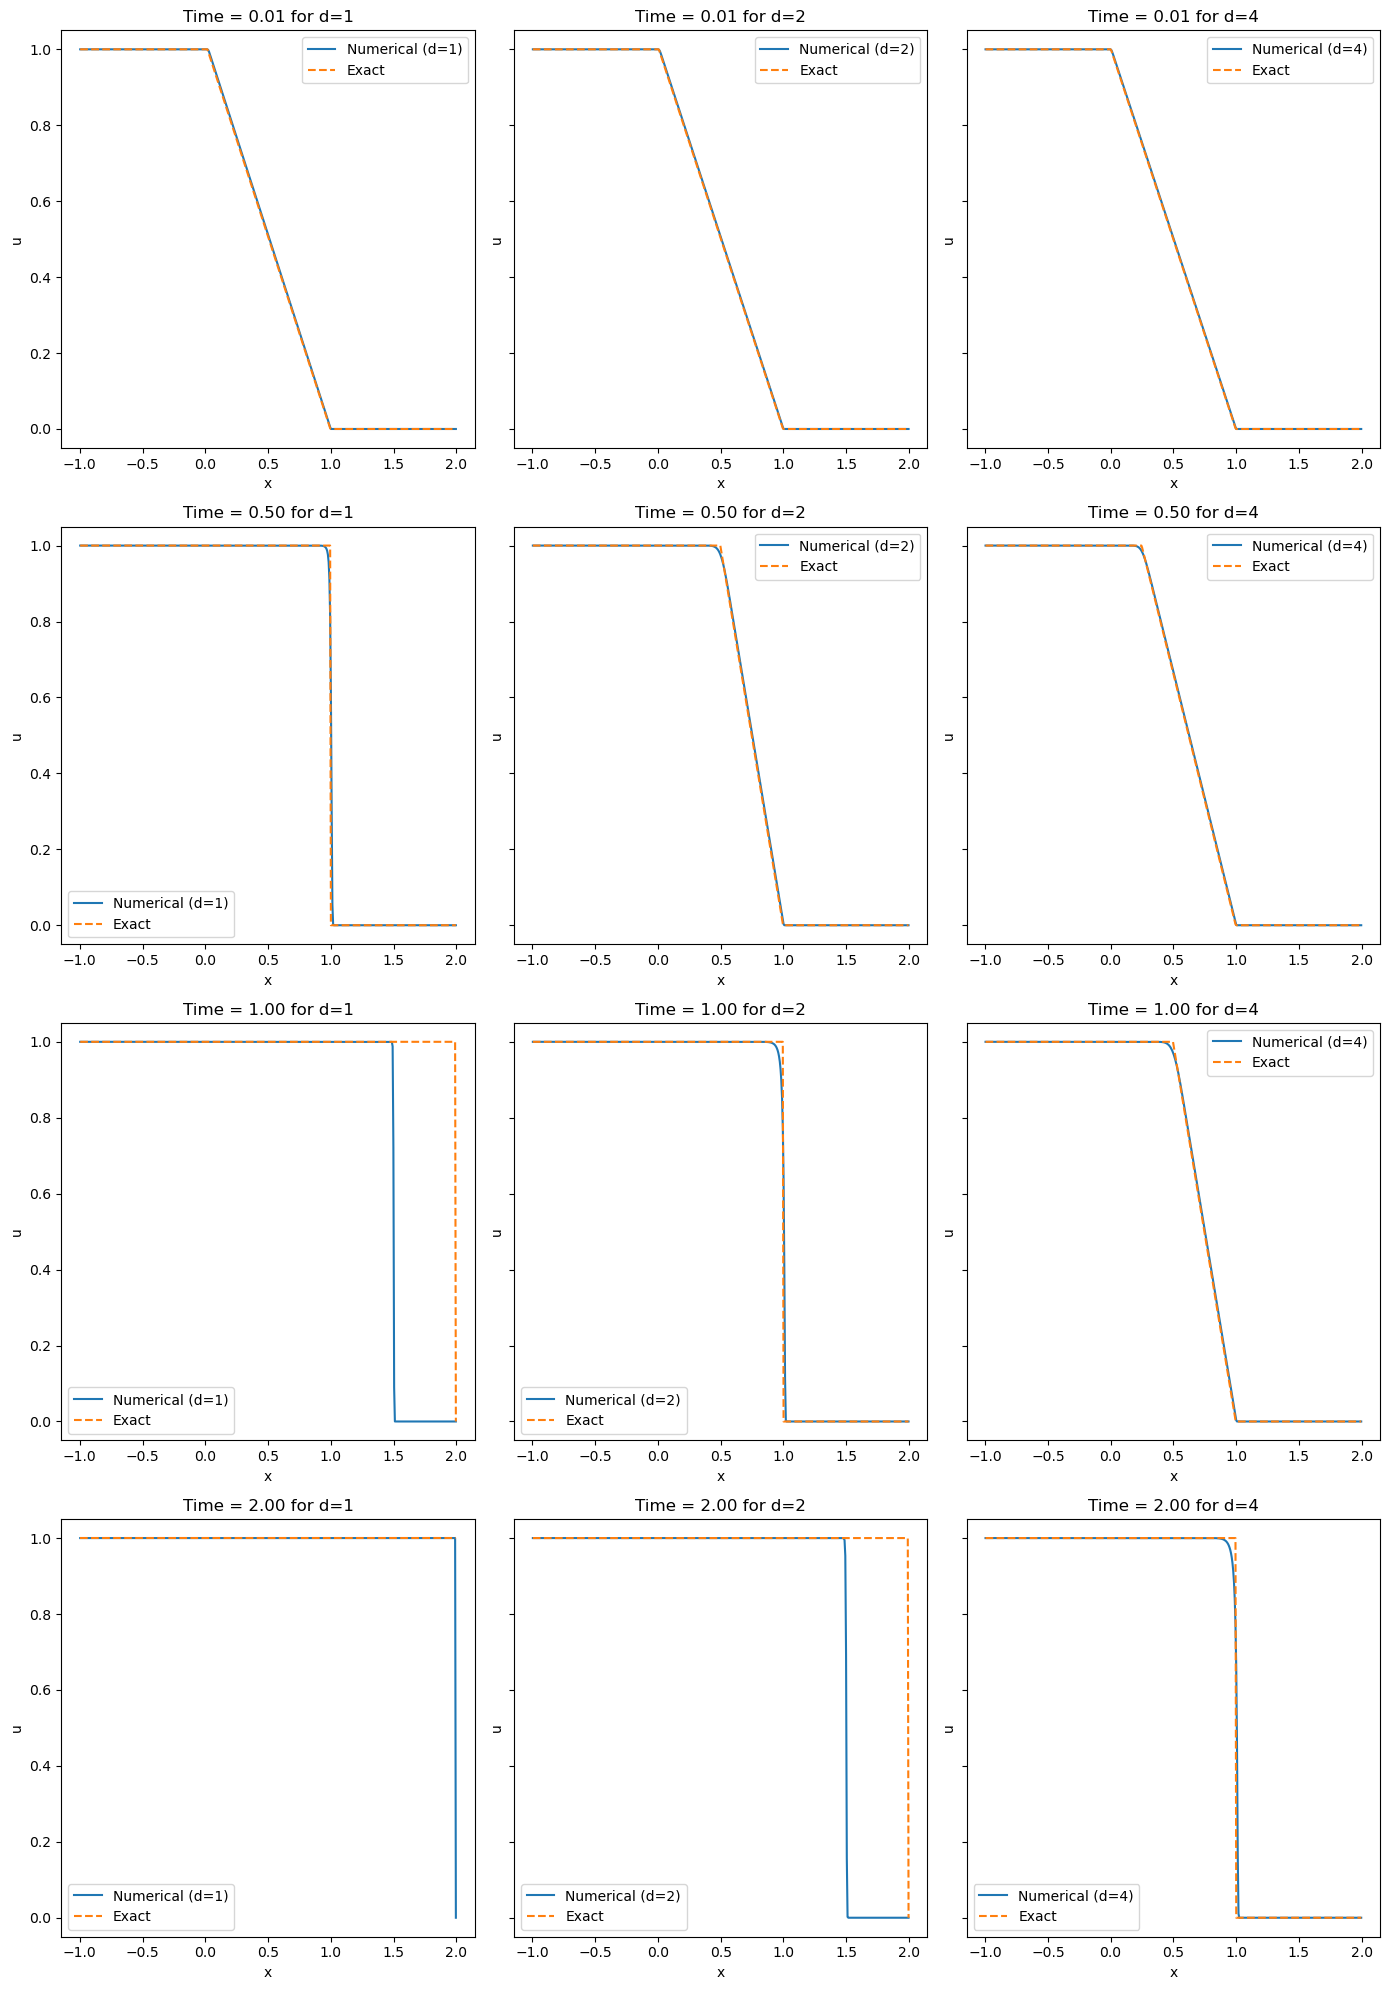

In [18]:
# Test case
def u0(x):
    if x < 0:
        return 1
    elif 0 <= x <= 1:
        return 1 - x
    else:
        return 0


T = [0.01, 0.5, 1.0, 2.0]
b = [-1, 2]
d = [1, 2, 4]
Nx = 500
cfl = 0.4
m = Mesh(Nx, b)


fig, axs = plt.subplots(4, 3, figsize=(14, 20), sharey=True)

for i, T_val in enumerate(T):
    for j, d_val in enumerate(d):
        x, u = Godunov_nonlinear(u0, b, d_val, Nx, cfl, T_val)

        u_exact = exact_non_lin_transport(m.x_half[1:], T_val, d_val)

        row = i  # Determine row based on index
        col = j  # Column

        axs[row, col].plot(x, u, label=f"Numerical (d={d_val})")
        axs[row, col].plot(x, u_exact, label="Exact", linestyle="--")

        axs[row, col].set_title(f"Time = {T_val:.2f} for d={d_val}")
        axs[row, col].legend()
        axs[row, col].set_xlabel("x")
        axs[row, col].set_ylabel("u")

plt.tight_layout()
plt.show()

- Since $u_L = 1 > 0 = u_R$, we directly have a shock wave.
- At early time, the numerical solutions follow the exact ones for both $d=1$ and $d=2$.
- At $t=1$ we can notice that for $d=1$ the numerical shock waves lag behind but with $d=2$ (i.e. Burgers flux) it looks better.
- At the final time $t=2$, the numerical solution for $d=1$ has a lot of dissipation compare to the exact one who's flattened. For Burgers the numerical solution lags behind but capture the shocks better
- We could try to refine the mesh even more (although I tried and doesn't seem to work) or use a higher order scheme to reduce the numerical diffusion.
